In [2]:
"""
the :mod:`knns` module includes some k-NN inspired algorithms.
"""
import heapq
import numpy as np
import pandas as pd

from surprise import AlgoBase, Dataset, Reader, accuracy, KNNWithMeans, KNNBasic, KNNBaseline, SVD
from surprise.model_selection import cross_validate
from surprise import PredictionImpossible
from surprise.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

import os

current_directory = os.getcwd()
print("Current working directory:", current_directory)


Current working directory: C:\Users\User\Desktop\MRes\src\Cred


In [3]:
def jaccard_sim(list1, list2):
    new_list1 = [x for i, x in enumerate(list1) if x != 0 or list2[i] != 0]
    new_list2 = [x for i, x in enumerate(list2) if x != 0 or list1[i] != 0]

    # Compute the intersection of the two lists, where each 1 or 0 is considered a value
    intersection = sum([1 for i in range(len(list1)) if list1[i] == 1 and list2[i] == 1])

    # Compute the union of the two lists, where each 1 or 0 is considered a value
    union = sum([1 for i in range(len(list1)) if list1[i] == 1 or list2[i] == 1])

    # Compute the Jaccard similarity
    jaccard_similarity = intersection / union
    return jaccard_similarity
    
# Load movie semantic data





u_header = ['item_id', 'title', 'date','date 2', 'IMDB', 'genre 1', 'genre 2', 'genre 3', 'genre 4', 'genre 5', 'genre 6', 'genre 7', 'genre 8', 'genre 9', 'genre 10', 'genre 11', 'genre 12', 'genre 13', 'genre 14', 'genre 15', 'genre 16', 'genre 17', 'genre 18', 'genre 19']
items_df = pd.read_csv('data/u.item', sep='|', names=u_header, encoding='latin')
items_df = items_df.drop('date', axis = 1)
items_df = items_df.drop('date 2', axis = 1)
items_df = items_df.drop('IMDB', axis = 1)
items_df = items_df.drop('title', axis = 1)

items_dict = items_df.set_index('item_id').T.to_dict('dict')

itemSemanticMatrix = np.zeros((len(items_df), len(items_df)))

for item_id1, item_genres1 in items_dict.items():
    genre_values1 = list(item_genres1.values())
    for item_id2, item_genres2 in items_dict.items():
        genre_values2 = list(item_genres2.values())
        itemSemanticMatrix[item_id1-1, item_id2-1] = jaccard_sim(genre_values1, genre_values2)        

print('Calculated Semantic Matrix')
print(itemSemanticMatrix)


Calculated Semantic Matrix
[[1.         0.         0.         ... 0.         0.33333333 0.        ]
 [0.         1.         0.33333333 ... 0.         0.         0.        ]
 [0.         0.33333333 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.5       ]
 [0.33333333 0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.5        0.         1.        ]]


In [4]:
def classify_age(age):
    if age <= 13: #17
        return 1 #'Children'
    elif age <= 25: #30
        return 2 #'Teenagers'
    elif age <= 40: #45
        return 3 #'Young Adults'
    elif age <= 50: #60
        return 4 #'Adults'
    else:
        return 5 #'Seniors'
    
# Load movie semantic data
u_header = ['user_id', 'age', 'sex','job', 'zipcode']
users_df = pd.read_csv('data/u.user', sep='|', names=u_header, encoding='latin')
users_df = users_df.drop('zipcode', axis = 1)
#users_df = users_df.drop('job', axis = 1)
#users_df = users_df.drop('sex', axis = 1)

users_df['ageGroup'] = users_df['age'].apply(classify_age)
users_df = users_df.drop('age', axis = 1)

users_dict = users_df.set_index('user_id').T.to_dict('dict')
#print(users_dict)

occup_list = ["administrator", "artist", "doctor", "educator", "engineer", "entertainment", "executive", "healthcare", "homemaker", "lawyer", "librarian", "marketing", "none", "other", "programmer", "retired", "salesman", "scientist", "student", "technician", "writer"]
age_group = [1, 2, 3, 4, 5]

userDemoGraphicMatrix = np.zeros((len(users_df), len(users_df)))

for user_id1, user_demo1 in users_dict.items():
    
    # 5 age group, 1 gender, 21 occupation
    demo_values1 = [0 for i in range(27)]    
    values1 = list(user_demo1.values())
    if(values1[0] == "M"):
        demo_values1[0] = 1
    for oc in range(len(occup_list)):
        if(values1[1] == occup_list[oc]):
            demo_values1[1+oc] = 1 
    for ag in range(len(age_group)):
        if(values1[2] == age_group[ag]):
            demo_values1[22+ag] = 1

    for user_id2, user_demo2 in users_dict.items():
        demo_values2 = [0 for i in range(27)]
        values2 = list(user_demo2.values())
        #print(user_id1, values1[0], values1[1], values1[2])
        if(values2[0] == "M"):
            demo_values2[0] = 1
        for oc2 in range(len(occup_list)):
            if(values2[1] == occup_list[oc2]):
                demo_values2[1+oc2] = 1
        for ag2 in range(len(age_group)):
            if(values2[2] == age_group[ag2]):
                demo_values2[22+ag2] = 1
        userDemoGraphicMatrix[user_id1-1, user_id2-1] = jaccard_sim(demo_values1, demo_values2)
        
print(userDemoGraphicMatrix)
print('Calculated Demographic Matrix')

[[1.  0.  0.5 ... 0.5 0.  0.5]
 [0.  1.  0.  ... 0.  0.  0. ]
 [0.5 0.  1.  ... 0.5 0.  0.5]
 ...
 [0.5 0.  0.5 ... 1.  0.  1. ]
 [0.  0.  0.  ... 0.  1.  0. ]
 [0.5 0.  0.5 ... 1.  0.  1. ]]
Calculated Demographic Matrix


In [5]:
# Important note: as soon as an algorithm uses a similarity measure, it should
# also allow the bsl_options parameter because of the pearson_baseline
# similarity. It can be done explicitly (e.g. KNNBaseline), or implicetely
# using kwargs (e.g. KNNBasic).

class SymmetricAlgo2(AlgoBase):
    """This is an abstract class aimed to ease the use of symmetric algorithms.
    A symmetric algorithm is an algorithm that can can be based on users or on
    items indifferently, e.g. all the algorithms in this module.
    When the algo is user-based x denotes a user and y an item. Else, it's
    reversed.
    """
    def __init__(self, sim_options={}, verbose=True, **kwargs):

        AlgoBase.__init__(self, sim_options=sim_options, **kwargs)
        self.verbose = verbose
        self.isSemantic = sim_options["isSemantic"]
        self.isDemographic = sim_options["isDemographic"]
        self.isJC = sim_options["isJC"]
        self.isCr = sim_options["isCr"]
        self.counter = 0
        if(self.isCr):
            %store -r Cr
            self.Cr = Cr
            print(Cr[0], Cr[1])
        
        if(self.isDemographic):
           print('isDemographic mode is on')

    def fit(self, trainset):

        AlgoBase.fit(self, trainset)

        ub = self.sim_options["user_based"]
        self.n_x = self.trainset.n_users if ub else self.trainset.n_items
        self.n_y = self.trainset.n_items if ub else self.trainset.n_users
        self.xr = self.trainset.ur if ub else self.trainset.ir
        self.yr = self.trainset.ir if ub else self.trainset.ur
        
        # Initilizating Semantic matrix
        if self.isSemantic:
            self.SemanticMatrix = np.zeros((self.n_x, self.n_x))
            for i in self.trainset.all_items():
                for j in self.trainset.all_items():
                    self.SemanticMatrix[i, j] = itemSemanticMatrix[int(self.trainset.to_raw_iid(i))-1, int(self.trainset.to_raw_iid(j))-1]
                    
        # Initilizating Demographic matrix
        if self.isDemographic:
            self.DemographicMatrix = np.zeros((self.n_x, self.n_x))
            for i in self.trainset.all_users():
                for j in self.trainset.all_users():
                    self.DemographicMatrix[i, j] = userDemoGraphicMatrix[int(self.trainset.to_raw_uid(i))-1, int(self.trainset.to_raw_uid(j))-1]
                    
        # Initilizating Cr matrix
        if self.isCr:
            self.CrMatrix = np.zeros((self.n_x, self.n_x))
            for i in self.trainset.all_users():
                #if(self.printLimit<20):
                #        print(self.Cr[int(self.trainset.to_raw_uid(i))-1], 'id:', int(self.trainset.to_raw_uid(i)))
                #        self.printLimit += 1
                for j in self.trainset.all_users():
                    self.CrMatrix[i, j] = 0 #self.Cr[int(self.trainset.to_raw_uid(i))-1]
                    if(i == j):
                        self.CrMatrix[i, j] = self.Cr[int(self.trainset.to_raw_uid(i))-1] #1
                        
        # Initialization of Jaccard matrix
        self.jaccardMatrix = np.zeros((self.n_x, self.n_x))
        count=0
        
        if(self.isJC):
            for i in range(self.n_x):
                i_list = [v[0] for v in self.xr[i]]
                i_set = set(i_list)
                for j in range(self.n_x):
                    j_list = [v[0] for v in self.xr[j]]
                    j_set = set(j_list)
                    jaccard_value = len(i_set.intersection(j_set)) / len(i_set.union(j_set))
                    self.jaccardMatrix[i][j] = jaccard_value
                    
        return self

    def switch(self, u_stuff, i_stuff):
        """Return x_stuff and y_stuff depending on the user_based field."""

        if self.sim_options["user_based"]:
            return u_stuff, i_stuff
        else:
            return i_stuff, u_stuff
    
#================================ KNNWithMeans2 ==============================#

class KNNWithMeans2(SymmetricAlgo2):
    """A basic collaborative filtering algorithm, taking into account the mean
    ratings of each user.
    Args:
        k(int): The (max) number of neighbors to take into account for
            aggregation (see :ref:`this note <actual_k_note>`). Default is
            ``40``.
        min_k(int): The minimum number of neighbors to take into account for
            aggregation. If there are not enough neighbors, the neighbor
            aggregation is set to zero (so the prediction ends up being
            equivalent to the mean :math:`\\mu_u` or :math:`\\mu_i`). Default is
            ``1``.
        sim_options(dict): A dictionary of options for the similarity
            measure. See :ref:`similarity_measures_configuration` for accepted
            options.
        verbose(bool): Whether to print trace messages of bias estimation,
            similarity, etc.  Default is True.
    """

    def __init__(self, k=40, min_k=1, sim_options={}, verbose=True, **kwargs):

        SymmetricAlgo2.__init__(self, sim_options=sim_options, verbose=verbose, **kwargs)

        self.k = k
        self.min_k = min_k

    def fit(self, trainset):

        SymmetricAlgo2.fit(self, trainset)
        
        self.sim = self.compute_similarities()
        
        if(self.isJC):
             self.sim = self.sim*self.jaccardMatrix
        
        if (self.isCr):
            #print(self.sim[0][0:4])
            #print('--------------------')
            #print(self.CrMatrix[0][0:4])
            #print('--------------------')
            self.sim = np.dot(self.sim , self.CrMatrix)
            #print(self.sim[0][0:4])
        
        if(self.isSemantic):
            self.sim2 = self.SemanticMatrix #self.sim*self.SemanticMatrix
        elif(self.isDemographic):
            self.sim2 = self.DemographicMatrix
        else:
            self.sim2 =  self.sim
            
        self.means = np.zeros(self.n_x)
        for x, ratings in self.xr.items():
            self.means[x] = np.mean([r for (_, r) in ratings])   

        return self

    def estimate(self, u, i):
        
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")

        x, y = self.switch(u, i)

        est = self.means[x]
        est1 = 0
        est2 = 0
                         
        # =========== general CF calculation =========== #
        neighbors = [(x_others, self.sim[x, x_others], r) for (x_others, r) in self.yr[y]]
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[1])
        
        # compute weighted average
        sum_sim = sum_ratings = actual_k = 0
        for (nb, sim, r) in k_neighbors:
            if sim > 0:
                sum_sim += sim
                sum_ratings += sim * (r - self.means[nb])
                actual_k += 1 
        
        if actual_k < self.min_k:
            sum_ratings = 0
        try:
            est1 += sum_ratings / sum_sim
        except ZeroDivisionError:
            pass  # return mean
        
        est1 = est1 + est
        
        # =========== semantic or demographic based CF calculation =========== #
        if(self.isSemantic or self.isDemographic):
            neighbors2 = [(x_others, self.sim2[x, x_others], r) for (x_others, r) in self.yr[y]]
            k_neighbors2 = heapq.nlargest(self.k, neighbors2, key=lambda t: t[1])
           
            # compute weighted average
            sum_sim2 = sum_ratings2 = actual_k2 = 0
            for (nb2, sim2, r2) in k_neighbors2:
                if sim2 > 0:
                    sum_sim2 += sim2
                    sum_ratings2 += sim2 * (r2 - self.means[nb2])
                    actual_k2 += 1
                   
            if actual_k2 < self.min_k:
                sum_ratings2 = 0
            try:
                est2 += sum_ratings2 / sum_sim2
            except ZeroDivisionError:
                pass  # return mean
            
            est2 = est2 + est
        
        if est1 == 0 and est2 != 0:
            est = est2
            details = {"actual_k2": actual_k2}
        elif est2 == 0 and est1 != 0:
            est = est1
            details = {"actual_k": actual_k}
        elif est1 + est2 == 0:
            print(est1, est2, self.means[x], self.min_k, actual_k)
            if(est1 > est2):
                est += est1
            else:
                est += est2
            details = {"actual_k": actual_k}
        else:
            est = (2 * est1 * est2)/(est1 + est2)
            #est += (est1 + est2)/2
            details = {"actual_k": actual_k, "actual_k2": actual_k2}
        
        return est, details
    

In [147]:
#========================================= Main functions starts here =============================================#
import random
import tensorflow as tf
from keras.regularizers import l2
from keras.optimizers import Adam

#from keras.models import Sequential
#from keras.layers import Dense

#data = Dataset.load_builtin("ml-100k")

# Load the u.data file into a dataset object
file_path = 'data/u.data2'
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_file(file_path, reader=reader)

# Compute the sparsity of the dataset
num_ratings = len(data.raw_ratings)
num_users = len(set([rating[0] for rating in data.raw_ratings]))
num_items = len(set([rating[1] for rating in data.raw_ratings]))
sparsity = 1.0 - (num_ratings / (num_users * num_items))

print(f"Number of ratings: {num_ratings}")
print(f"Number of users: {num_users}")
print(f"Number of items: {num_items}")
print(f"Sparsity: {sparsity:.3f}")

# Load the dataset
trainset, testset = train_test_split(data, test_size=0.2)

sim_options_forUserBased = {
    "name": "cosine",
    "user_based": True,  # compute  similarities between items
    "isSemantic": False,
    "isDemographic": True,
    "isJC": True,
    "isCr": False
}

sim_options_forItemBased = {
    "name": "cosine",
    "user_based": False,  # compute  similarities between items
    "isSemantic": True,
    "isDemographic": False,
    "isJC": True,
    "isCr": False
}

#algo = KNNBasic2(5, sim_options=sim_options)
#algo = KNNBaseline2(10, sim_options=sim_options)
#algo = KNNWithMeans2(10, sim_options=sim_options_forUserBased)
#cross_validate(algo, data, verbose=True)
#user_based_cf = KNNBasic2(2, sim_options=sim_options_forUserBased)
#user_based_cf = KNNWithMeans2(5, sim_options=sim_options_forUserBased)

#cross_validate(user_based_cf, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

# User-based CF
user_based_cf = KNNWithMeans2(10, sim_options=sim_options_forUserBased)
user_based_cf.fit(trainset)

# Item-based CF
item_based_cf = KNNWithMeans2(10, sim_options=sim_options_forItemBased)
item_based_cf.fit(trainset)

# Make predictions using the user-user and item-item models
user_predictions = [user_based_cf.predict(uid=str(uid), iid=str(iid)).est for (uid, iid, _) in testset]
item_predictions = [item_based_cf.predict(uid=str(uid), iid=str(iid)).est for (uid, iid, _) in testset]

user_predictions = np.array(user_predictions).reshape(-1, 1)
item_predictions = np.array(item_predictions).reshape(-1, 1)

# Concatenate the predictions
all_predictions = np.concatenate((user_predictions, item_predictions), axis=1)

all_predictions = np.array(all_predictions, dtype=np.float32)

# Define the architecture of the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'), #kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(1, activation=None),
])

# Compile the model with the mean squared error loss
model.compile(optimizer='adam', loss='mean_squared_error') # Adam(learning_rate=0.0001)
test_ratings = np.array([rating[2] for rating in testset], dtype=np.float32)

# Train the model using the concatenated predictions
model.fit(all_predictions, test_ratings, epochs=25, batch_size=32)

# Make predictions on the test set using the neural network
nn_predictions = model.predict(all_predictions)

# Compute overall MAE and RMSE for the neural network
mae_nn = np.mean(np.abs(np.array([nn_predictions[i][0] for i in range(len(nn_predictions))]) - np.array([r for (_, _, r) in testset])))
rmse_nn = np.sqrt(np.mean(np.square(np.array([nn_predictions[i][0] for i in range(len(nn_predictions))]) - np.array([r for (_, _, r) in testset]))))

user_based_pred = user_based_cf.test(testset)
item_based_pred = item_based_cf.test(testset)

print('User based KNN:', accuracy.rmse(user_based_pred), accuracy.mae(user_based_pred))
print('Item based KNN:', accuracy.rmse(item_based_pred), accuracy.mae(item_based_pred))
# Print the results
print("NN Overall MAE:", mae_nn)
print("NN Overall RMSE:", rmse_nn)

print("Complete.")

Number of ratings: 80000
Number of users: 943
Number of items: 1643
Sparsity: 0.948
isDemographic mode is on
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Epoch 1/25
500/500 [==============================] - 1s 2ms/step - loss: 2.7199
Epoch 2/25
500/500 [==============================] - 1s 2ms/step - loss: 0.8493
Epoch 3/25
500/500 [==============================] - 1s 2ms/step - loss: 0.8478
Epoch 4/25
500/500 [==============================] - 1s 2ms/step - loss: 0.8465
Epoch 5/25
500/500 [==============================] - 1s 2ms/step - loss: 0.8465
Epoch 6/25
500/500 [==============================] - 1s 1ms/step - loss: 0.8446
Epoch 7/25
500/500 [==============================] - 1s 1ms/step - loss: 0.8459
Epoch 8/25
500/500 [==============================] - 1s 1ms/step - loss: 0.8460
Epoch 9/25
500/500 [==============================] - 1s 1ms/step - loss: 0.8464
Epoch 10/2

MAE:  0.8053


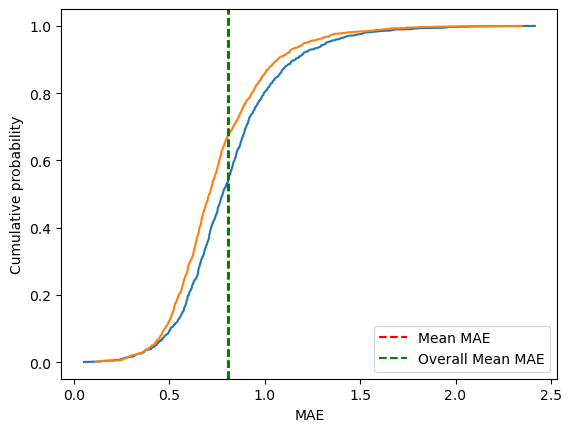

In [103]:
# Compute the per-user MAE
user_errors = {}
user_counts = {}
for uid, iid, true_r, est, _ in user_based_pred:
    error = abs(true_r - est)
    if uid in user_errors:
        user_errors[uid] += error
        user_counts[uid] += 1
    else:
        user_errors[uid] = error
        user_counts[uid] = 1

mae_per_user = {}
for uid in user_errors:
    mae_per_user[uid] = user_errors[uid] / user_counts[uid]
    
# Compute the per-user MAE
user_errors2 = {}
user_counts2 = {}
for uid, iid, true_r, est, _ in item_based_pred:
    error = abs(true_r - est)
    if uid in user_errors2:
        user_errors2[uid] += error
        user_counts2[uid] += 1
    else:
        user_errors2[uid] = error
        user_counts2[uid] = 1

mae_per_user2 = {}
for uid in user_errors2:
    mae_per_user2[uid] = user_errors2[uid] / user_counts2[uid]

# Print the overall MAE and the per-user MAE
#print(f"Overall MAE: {mae_overall}")
#for uid, mae in mae_per_user.items():
#    print(f"User {uid}: MAE = {mae}")

import matplotlib.pyplot as plt
import numpy as np
# Plot the cumulative distribution of each user's MAE

mae_values = list(mae_per_user.values())
mae_values.sort()
n_users = len(mae_values)
cumulative_probs = [float(i) / n_users for i in range(1, n_users + 1)]
plt.plot(mae_values, cumulative_probs)

mae_values2 = list(mae_per_user2.values())
mae_values2.sort()
n_users2 = len(mae_values2)
cumulative_probs2 = [float(i) / n_users2 for i in range(1, n_users2 + 1)]
plt.plot(mae_values2, cumulative_probs2)

# Draw a vertical line at the mean point
mean_mae = np.mean(mae_values)
plt.axvline(x=mean_mae, linestyle='--', color='r', label='Mean MAE')

# Draw a vertical line at the overall mean MAE
plt.axvline(x=accuracy.mae(user_based_pred), linestyle='--', color='g', label='Overall Mean MAE')

# Label the axes and add a legend
plt.xlabel('MAE')
plt.ylabel('Cumulative probability')
plt.legend()

# Show the plot
plt.show()


In [65]:
# Prepare input data
inputs = []
targets = []
my_trainset= []
count = 0
for user, item, true_rating in trainset.all_ratings():
    uid = trainset.to_raw_uid(user)
    iid = trainset.to_raw_iid(item)
    user_based_pred = user_based_cf.predict(uid, iid).est
    item_based_pred = item_based_cf.predict(uid, iid).est
    my_trainset.append([uid, iid, true_rating])
    inputs.append([user_based_pred, item_based_pred])
    targets.append([float(true_rating)])

for d in range(10):
    print(inputs[d], targets[d])    

inputs = torch.tensor(inputs)
targets = torch.tensor(targets)

inputs = inputs.to(torch.float)
targets = targets.to(torch.float)

print(inputs.shape)
print(targets.shape)

[3.3058842230753873, 3.051089329498509] [3.0]
[3.8176497981065216, 4.099972903969075] [5.0]
[1.8835706927778444, 2.0787276776027763] [1.0]
[2.8261930345344624, 3.612869231133763] [4.0]
[3.789653482722187, 4.266837532805477] [5.0]
[3.503805971059883, 3.539620304635137] [4.0]
[3.4322814648189754, 3.9526574887741304] [4.0]
[3.727886533969657, 3.7474553777663817] [4.0]
[2.2502453144608117, 2.7183210291337234] [1.0]
[3.3151903795055664, 3.666659359466107] [3.0]
torch.Size([90000, 2])
torch.Size([90000, 1])


In [64]:
#import torch

#import torch.nn as nn
#import torch.optim as optim
#from torch.utils.data import DataLoader, random_split
#from torch_lr_finder import LRFinder

#from torch.utils.data import TensorDataset




In [114]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define the MLP architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the neural network
class SingleLayerNet(nn.Module):
    def __init__(self):
        super(SingleLayerNet, self).__init__()
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x
    
inputs_mean = inputs.mean(dim=0)
inputs_std = inputs.std(dim=0)
targets_mean = targets.mean(dim=0)
targets_std = targets.std(dim=0)
inputs = (inputs - inputs_mean) / inputs_std
targets = (targets - targets_mean) / targets_std
'''
# Initialize the MLP and optimizer
mlp = MLP()
optimizer = optim.Adam(mlp.parameters(), lr=0.003)

# Train the MLP
criterion = nn.MSELoss()
num_epochs = 200

for epoch in range(num_epochs):
    # Forward pass
    outputs = mlp(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
'''

# Initialize the neural network and optimizer
net = SingleLayerNet()
#optimizer = optim.SGD(net.parameters(), lr=0.003)
optimizer = optim.SGD(net.parameters(), lr=0.08, weight_decay=0.01)

# Train the neural network
criterion = nn.MSELoss()
num_epochs = 200

for epoch in range(num_epochs):
    # Forward pass
    outputs = net(inputs)
    #outputs = outputs.squeeze() # Remove extra dimension
    
    loss = criterion(outputs, targets)
    
    # L2 regularization
    l2_lambda = 0.01
    l2_reg = torch.tensor(0.)
    for name, param in net.named_parameters():
        if 'weight' in name:
            l2_reg += torch.norm(param)

    loss += l2_lambda * l2_reg

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
        
print('MLP trained')


Using cpu device
Epoch [10/200], Loss: 0.4255
Epoch [20/200], Loss: 0.4175
Epoch [30/200], Loss: 0.4145
Epoch [40/200], Loss: 0.4125
Epoch [50/200], Loss: 0.4113
Epoch [60/200], Loss: 0.4105
Epoch [70/200], Loss: 0.4100
Epoch [80/200], Loss: 0.4096
Epoch [90/200], Loss: 0.4094
Epoch [100/200], Loss: 0.4092
Epoch [110/200], Loss: 0.4091
Epoch [120/200], Loss: 0.4090
Epoch [130/200], Loss: 0.4090
Epoch [140/200], Loss: 0.4090
Epoch [150/200], Loss: 0.4089
Epoch [160/200], Loss: 0.4089
Epoch [170/200], Loss: 0.4089
Epoch [180/200], Loss: 0.4089
Epoch [190/200], Loss: 0.4089
Epoch [200/200], Loss: 0.4089
MLP trained


In [115]:
print('checking the performance against the trained data set')
total_mse = 0
total_rmse = 0
total_mae = 0
countt = 0

# Compute mean and standard deviation of training data
inputs_mean = inputs.mean(dim=0)
inputs_std = inputs.std(dim=0)

for uid, iid, true_r in my_trainset:
    test_user_based_pred = user_based_cf.predict(uid, iid).est
    test_item_based_pred = item_based_cf.predict(uid, iid).est
    
    # Normalize test data using mean and standard deviation of training data
    test_input_data = torch.tensor([[test_user_based_pred, test_item_based_pred]])
    test_input_data = (test_input_data - inputs_mean) / inputs_std
    test_input_data = test_input_data.to(torch.float).detach()
    
    # Make predictions and compute evaluation metrics
    test_predicted_rating = net(test_input_data).item()
    diff = test_predicted_rating - true_r
    total_mse += diff ** 2
    total_rmse += diff ** 2
    total_mae += abs(diff)

mse = total_mse / len(my_trainset)
print(f"Mean Squared Error: {mse}")

n_testset = len(my_trainset)
rmse = (total_rmse / n_testset) ** 0.5
mae = total_mae / n_testset

print("RMSE:", rmse)
print("MAE:", mae)


checking the performance against the trained data set
Mean Squared Error: 1.1355617807248963
RMSE: 1.0656274117743483
MAE: 0.9018302797860569


In [86]:
print('checking the performance against the test data set')
total_mse = 0
total_rmse = 0
total_mae = 0
countt = 0

# Compute mean and standard deviation of training data
inputs_mean = inputs.mean(dim=0)
inputs_std = inputs.std(dim=0)

for uid, iid, true_r in testset:
    test_user_based_pred = user_based_cf.predict(uid, iid).est
    test_item_based_pred = item_based_cf.predict(uid, iid).est
    
    # Normalize test data using mean and standard deviation of training data
    test_input_data = torch.tensor([[test_user_based_pred, test_item_based_pred]])
    test_input_data = (test_input_data - inputs_mean) / inputs_std
    test_input_data = test_input_data.to(torch.float).detach()
    
    # Make predictions and compute evaluation metrics
    # test_predicted_rating = mlp(test_input_data).item()
    test_predicted_rating = net(test_input_data).item()
    diff = test_predicted_rating - true_r
    total_mse += diff ** 2
    total_rmse += diff ** 2
    total_mae += abs(diff)

mse = total_mse / len(testset)
print(f"Mean Squared Error: {mse}")

n_testset = len(testset)
rmse = (total_rmse / n_testset) ** 0.5
mae = total_mae / n_testset

print("RMSE:", rmse)
print("MAE:", mae)


checking the performance against the test data set
Mean Squared Error: 1.3922362004634041
RMSE: 1.1799305913753588
MAE: 0.9952515847921372
